In [1]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
from keras import layers
import os

In [2]:
# CARREGANDO A PLANILHA
df = pd.read_excel('C:/Users/Meu Computador/Documents/Tubaroes/SP_Reconstrucao_Siluriformes_2024_12_16.xlsx')

pasta_pesos = r'C:/Users/Meu Computador/Documents/Tubaroes/pesos_prop_Bagre_art'
os.makedirs(pasta_pesos, exist_ok=True)

# SELECIONANDO COLUNAS DE INTERESSE
df_bagre = df[['Ano','Bagre_art','Bagre_ind','Bagre_art_ind']]

# DEFININDO OS ANOS QUE PRECISAMOS DESAGREGAR
#    Com base na sua observação, serão: 1962, 1966 – 1967, 1976 – 1977 e 1995 – 1997.
anos_para_prever = np.array([1962, 1966, 1967, 1976, 1977, 1995, 1996, 1997])

# CORRIGINDO VALORES DE 'Bagre_art_ind' CASO EXISTA ALGUM ANO
#    EM QUE 'Bagre_art_ind' ESTEJA VAZIO (NaN), MAS 'Bagre_art' e 'Bagre_ind' NÃO.
for i in range(len(df_bagre)):
    # Se Bagre_art_ind estiver vazio, mas Bagre_art e Bagre_ind não:
    if (pd.isnull(df_bagre.loc[i,'Bagre_art_ind']) 
        and not pd.isnull(df_bagre.loc[i,'Bagre_art']) 
        and not pd.isnull(df_bagre.loc[i,'Bagre_ind'])):
        
        df_bagre.loc[i,'Bagre_art_ind'] = df_bagre.loc[i,'Bagre_art'] + df_bagre.loc[i,'Bagre_ind']

# FILTRANDO OS DADOS QUE TÊM REGISTROS VÁLIDOS (sem NaN) E REINDEXANDO
df_bagre = df_bagre[['Ano','Bagre_art','Bagre_ind','Bagre_art_ind']].dropna().reset_index(drop=True)

# CRIANDO UMA COLUNA COM A SOMA (Bagre_art + Bagre_ind)
df_bagre['Soma'] = df_bagre['Bagre_art'] + df_bagre['Bagre_ind']

# SEPARANDO AS ESPÉCIES PARA FAZER A PROPORÇÃO
especies = ['Bagre_art','Bagre_ind']

# CALCULANDO AS PROPORÇÕES DE CADA ESPÉCIE EM RELAÇÃO À SOMA
lista_de_prop = []

# loop para cada espécie:
for esp in especies:
    # Cria um DataFrame intermediário para conferir a lógica
    dados = df_bagre[['Ano', esp, 'Soma']].copy()
    
    # Calcula a proporção
    dados[f'Prop_{esp}'] = dados[esp] / dados['Soma']
    
    # Adiciona à lista_de_prop
    lista_de_prop.append(dados[f'Prop_{esp}'].values)
    
    
    print(f"\nEspécie: {esp}")
    print(dados.head())  # Mostra as 5 primeiras linhas

# ORGANIZANDO OS VETORES DE ANOS
anos_com_dados = df_bagre['Ano'].values
todos_anos = np.concatenate((anos_para_prever, anos_com_dados))
todos_anos.sort()


Espécie: Bagre_art
    Ano  Bagre_art    Soma  Prop_Bagre_art
0  1959     112.00  193.00        0.580311
1  1960      65.00  112.00        0.580357
2  1961     102.93  177.37        0.580312
3  1963      83.50  143.88        0.580345
4  1964      67.69  116.64        0.580333

Espécie: Bagre_ind
    Ano  Bagre_ind    Soma  Prop_Bagre_ind
0  1959      81.00  193.00        0.419689
1  1960      47.00  112.00        0.419643
2  1961      74.44  177.37        0.419688
3  1963      60.38  143.88        0.419655
4  1964      48.95  116.64        0.419667


In [3]:
# NORMALIZAÇÃO DOS ANOS
ano_mean = np.mean(anos_com_dados)
ano_std = np.std(anos_com_dados)

anos_para_prever_norm = (anos_para_prever - ano_mean) / ano_std
anos_com_dados_norm   = (anos_com_dados  - ano_mean) / ano_std

# NORMALIZAÇÃO DAS PROPORÇÕES (uma para cada espécie)
lista_prop_norm = []
lista_prop_mean = []
lista_prop_std  = []

for prop in lista_de_prop:
    prop_mean = np.mean(prop)
    prop_std  = np.std(prop)
    
    prop_norm = (prop - prop_mean) / (prop_std if prop_std != 0 else 1e-9)  # Evita divisão por zero
    lista_prop_norm.append(prop_norm)
    lista_prop_mean.append(prop_mean)
    lista_prop_std.append(prop_std if prop_std != 0 else 1e-9)

print(lista_prop_norm)


[array([ 0.7560624 ,  0.75625284,  0.75606842,  0.75620175,  0.75615201,
        0.75624504,  0.75613677,  0.75614914,  0.75612015,  0.75616143,
        0.75618247, -1.61722988, -1.49998264, -1.4395419 , -1.32362982,
       -1.05238156, -0.99455913, -1.30449089,  0.45836731, -0.14269437,
        0.31276592, -0.5190312 , -0.27925764, -1.05743818, -1.07208   ,
       -0.96995007, -1.6119255 , -1.01944913, -0.84613686, -1.47024231,
       -0.98791925,  0.00853361,  0.50183881,  1.11965493,  0.83788433,
        1.01789378,  0.4291172 ,  1.1094031 ,  0.20812776, -0.21344946,
        0.16019859,  1.29104571, -0.57198392, -0.47676304,  0.58737966,
        1.46105045,  0.13973245,  1.88901452, -0.67011211, -1.15801888,
        2.44852723]), array([-0.7560624 , -0.75625284, -0.75606842, -0.75620175, -0.75615201,
       -0.75624504, -0.75613677, -0.75614914, -0.75612015, -0.75616143,
       -0.75618247,  1.61722988,  1.49998264,  1.4395419 ,  1.32362982,
        1.05238156,  0.99455913,  1.30449

In [4]:
# DEFININDO FUNÇÃO DE TREINO (FIT) DA REDE PARA AS PROPORÇÕES
def Fit_das_proporcoes(anos_norm,
                       lista_prop_norm,
                       lista_de_epocas,
                       lista_de_otimizadores,
                       lista_de_overwrite,
                       especies):
    
    # Definindo um único modelo sequencial com as camadas, assim como no código original
    model = keras.Sequential([
        layers.Dense(96, activation='leaky_relu', input_shape=(1,)),
        layers.Dense(32, activation='leaky_relu'),
        layers.Dense(80, activation='leaky_relu'),
        layers.Dense(80, activation='leaky_relu'),
        layers.Dense(96, activation='leaky_relu'),
        layers.Dense(112, activation='leaky_relu'),
        layers.Dense(1, activation='linear')
    ])
    
    lista_de_loss = []
    
    # TREINAMENTO PARA CADA ESPÉCIE
    for k, esp in enumerate(especies):
        opt = lista_de_otimizadores[k]
        model.compile(optimizer=opt, loss='mse')
        
        history = model.fit(
            anos_norm,
            lista_prop_norm[k],
            epochs=lista_de_epocas[k],
            verbose=0
        )
        lista_de_loss.append(history.history['loss'])
        
        # Salvando pesos em pasta correspondente (ajuste o caminho ao seu ambiente)
        model.save_weights(os.path.join(pasta_pesos, '.weights.h5'), overwrite=True)
    
    return model, lista_de_loss

In [5]:
# CHAMANDO A FUNÇÃO PARA FAZER O FIT DO MODELO
Adam  = keras.optimizers.Nadam(learning_rate=0.001)
Nadam = keras.optimizers.Adam(learning_rate=0.001)


lista_de_epocas      = [100, 100]       
lista_de_otimizadores= [Nadam, Nadam]  
lista_de_overwrite   = [True, True]

model, lista_de_loss = Fit_das_proporcoes(
    anos_com_dados_norm,
    lista_prop_norm,
    lista_de_epocas,
    lista_de_otimizadores,
    lista_de_overwrite,
    especies
)

In [6]:
lista_de_previsoes = []
lista_fits = []

# Por exemplo, um range de anos normalizado para plot (p)
p = np.linspace(-2, 2, 50)

for k, esp in enumerate(especies):
    # Carregamos os pesos de cada espécie
    model.load_weights(f'C:/Users/Meu Computador/Documents/Tubaroes/pesos_prop_Bagre_art/.weights.h5')
    
    # Previsões para anos ausentes
    prev_ausentes = model.predict(anos_para_prever_norm)
    prev_ausentes = prev_ausentes * lista_prop_std[k] + lista_prop_mean[k]
    
  
    fit_valores = model.predict(p)
    fit_valores = fit_valores * lista_prop_std[k] + lista_prop_mean[k]
    
    # Ajustando valores para que fiquem entre 0 e 1
    prev_ausentes[prev_ausentes < 0] = 0
    prev_ausentes[prev_ausentes > 1] = 1
    
    lista_de_previsoes.append(prev_ausentes)
    lista_fits.append(fit_valores)

2/2 [==============================] - 0s 1ms/step


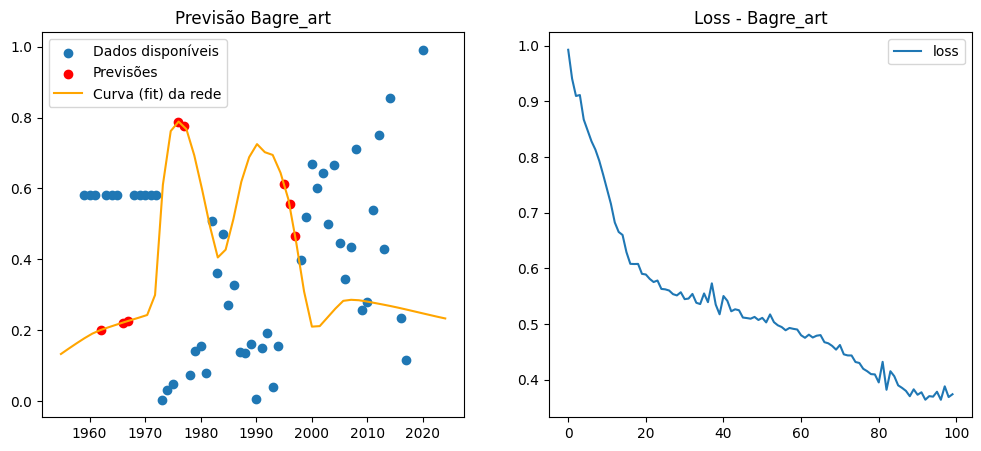

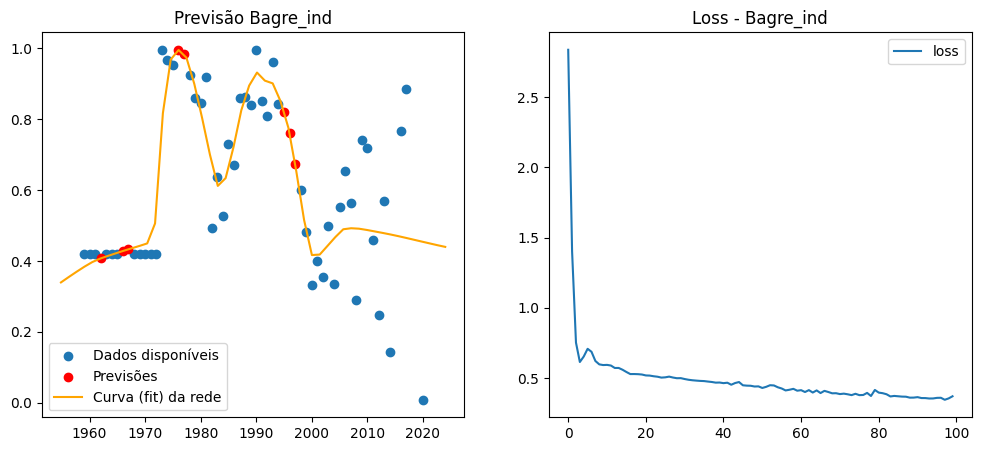

In [7]:
for k, esp in enumerate(especies):
    plt.figure(figsize=(12,5))
    
    # Plot scatter dos dados disponíveis
    plt.subplot(1,2,1)
    plt.scatter(anos_com_dados, lista_de_prop[k], label='Dados disponíveis')
    plt.scatter(anos_para_prever, lista_de_previsoes[k], color='red', label='Previsões')
    # Plot do fit
    plt.plot(p*ano_std + ano_mean, lista_fits[k], color='orange', label='Curva (fit) da rede')
    plt.title(f'Previsão {esp}')
    plt.legend()
    
    # Plot do loss
    plt.subplot(1,2,2)
    plt.plot(lista_de_loss[k], label='loss')
    plt.title(f'Loss - {esp}')
    plt.legend()
    
    plt.show()

In [ ]:
ano_inicial = min(anos_para_prever)
ano_final   = max(anos_para_prever)

anos = np.arange(ano_inicial, ano_final+1)
anos_norm = (anos - ano_mean)/ano_std

# FAZENDO PREVISÕES “CONTÍNUAS” PARA CADA ESPÉCIE (SÓ PARA EXEMPLO)
lista_prev_continua = []
for k, esp in enumerate(especies):
    model.load_weights(f'C:/Users/Meu Computador/Documents/Tubaroes/pesos_prop_Bagre_art/.weights.h5')
    prev = model.predict(anos_norm)
    prev = prev * lista_prop_std[k] + lista_prop_mean[k]

    # Ajuste de min e max (entre 0 e 1)
    prev[prev < 0] = 0
    prev[prev > 1] = 1
    
    lista_prev_continua.append(prev.flatten())

2/2 [==============================] - 0s 1ms/step


In [ ]:
prop_soma = np.zeros(len(anos))
for k in range(len(especies)):
    prop_soma += lista_prev_continua[k]

# Evitar dividir por zero
prop_soma[prop_soma == 0] = 1e-9

for k in range(len(especies)):
    lista_prev_continua[k] = lista_prev_continua[k] / prop_soma

# CRIANDO UM NOVO DATAFRAME COM AS PREVISÕES
df_prev = pd.DataFrame({
    'Ano': anos,
    especies[0]: lista_prev_continua[0],
    especies[1]: lista_prev_continua[1]
})

In [ ]:
df_para_desagregar = df[['Ano','Bagre_art_ind']].copy()

# Mesclar/loc para criar a desagregação final:
df_final = df_para_desagregar.merge(df_prev, on='Ano', how='left')

# Onde houver proporção calculada, multiplicamos pela soma
df_final['Bagre_art_prev'] = df_final['Bagre_art_ind'] * df_final[especies[0]]
df_final['Bagre_ind_prev'] = df_final['Bagre_art_ind'] * df_final[especies[1]]

# SALVAR EM EXCEL
df_final.to_excel(
    'C:/Users/Meu Computador/Documents/Tubaroes/Desagregacao_Bagre_art_ind.xlsx',
    index=False
)

# Pronto!
print(df_final.head(15))

     Ano  Bagre_art_ind  Bagre_art  Bagre_ind  Bagre_art_prev  Bagre_ind_prev
0   1950            NaN        NaN        NaN             NaN             NaN
1   1951            NaN        NaN        NaN             NaN             NaN
2   1952            NaN        NaN        NaN             NaN             NaN
3   1953            NaN        NaN        NaN             NaN             NaN
4   1954            NaN        NaN        NaN             NaN             NaN
5   1955            NaN        NaN        NaN             NaN             NaN
6   1956            NaN        NaN        NaN             NaN             NaN
7   1957            NaN        NaN        NaN             NaN             NaN
8   1958            NaN        NaN        NaN             NaN             NaN
9   1959            NaN        NaN        NaN             NaN             NaN
10  1960            NaN        NaN        NaN             NaN             NaN
11  1961            NaN        NaN        NaN             NaN   